# Website new vs old, what version we should use?

## Content

### - Introduction
### - Description of the dataframe
### - Developing A/B test
### - Collecting and preparing the data
### - Testing hypotesis
### - Visualization
### - Conclusion

# Introduction
Working for an early-stage startup, the team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site, increasing the current conversion rate. Using and A/B test on a subset of user database we will determine if the old design is better than the new ones.

# Description of the dataframe 

#### Column description

- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.
- "n_count" - count of values in dataframe for each design type
- "percent_rate" - percent of values in dataframe for each design type
- "group" - group of each desing type

The control group is those users with "no" in both columns: the old version with the old set of images. Treatment = 0, New images = 0.

In [ ]:
#libraries used for analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import scipy.stats as stats
from scipy.stats import norm



In [ ]:
df = pd.read_csv('./data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


A we can saw in the info() of the database, we have 40483 entries.

Dtype of the column:
- Treatment: object
- New images: object
- Converted: int64

Searching for NaN values with isna().sum(), it looks like all the columns are complete.

To help with the analysis we will convert all the str values to int. No = 0, Yes = 1

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB
None


In [ ]:
print(df.isna().sum())
df.replace({'yes': 1, 'no': 0},inplace=True)

treatment     0
new_images    0
converted     0
dtype: int64


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   treatment   40484 non-null  int64
 1   new_images  40484 non-null  int64
 2   converted   40484 non-null  int64
dtypes: int64(3)
memory usage: 949.0 KB
None


#### Conversion rates analysis

Looking for the conversion rates of the old / new designs the values where grouped by treatment and new_images column, after that, we created the column n_count to count the total entries for each design. 

To count the conversion rate we divide the number of entries from each design by the total lenght of the dataframe and multiply by 100 to give us the conv_rate column.

As we can see the Mean and Std of the conversion asre 11.34% and 31.70% respectively

In [ ]:
df_values = df.groupby(['treatment','new_images'])['converted'].value_counts().rename('n_count').reset_index(2)
df_values['percent_rate'] = (df_values['n_count']/len(df)).mul(100)

df_values

converted  n_count  percent_rate
treatment new_images                                  
0         0                   0     9037     22.322399
          0                   1     1084      2.677601
          1                   0     8982     22.186543
          1                   1     1139      2.813457
1         0                   0     8906     21.998814
          0                   1     1215      3.001186
          1                   0     8970     22.156901
          1                   1     1151      2.843099

In [ ]:
print('Mean of the conversion rate:' + str(df.converted.mean()))
print('Std of the conversion rate:' + str(df.converted.std()))

Mean of the conversion rate:0.11335342357474558
Std of the conversion rate:0.31702824412260483


In the graph below, as with the Df with the conversion rates, where we plot the new/old designs, it shows that most of the conversion rates where the user is converted or "join" to the page are very low, not surpassing the number of 1215, or 3%  of the total count of the Df. 

In all the desgins old/new where the user joins the conversion rate is between 2.6 % and 3.002 %, while in the opposite escenarios the range goes around 21 % and 22.4 %. 

With this visual analysis and looking from the conversion rate colum, we could jump to the conclusion that the redesign of the site does not bring an improvement to the conversion rate.

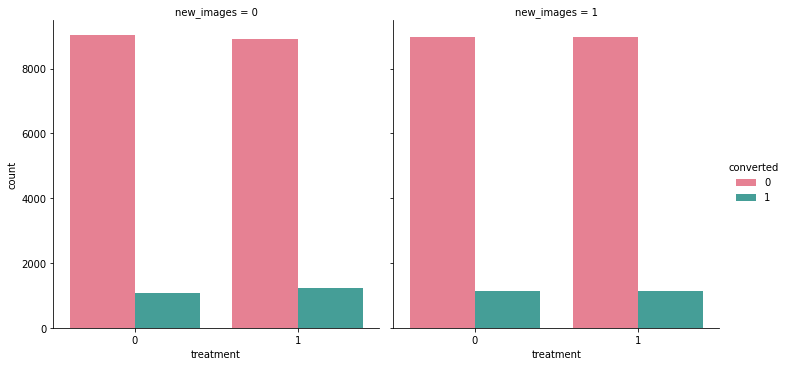

In [ ]:

sns.catplot(x ='treatment',data = df, kind = 'count', col = 'new_images',hue='converted',palette="husl")

## Developing A/B test

#### Formulating the hypotesis

Given we don´t know if the new designs will perform better or worse as our current design we will choose an two tailed test.

Ho: p = p0

Ha : p /= p0

Where p and p0 stand for the conversion rate of the old and new designs respectively. We will set a confidence level of 95%.

α = 0.05

The a value will be our threshold, meaning if it the p-value is less than 0.05 we will reject the null hypotesis Ho. Our confidence will be (1-α) = 95%

#### Choosing varaibles

For our test four groups will be created

- Control group A - Showing the old design
- Treatment group B - Showing new design 
- Treatment group C - Showing new design
- Treatment group D - Showing new design

This will be our independent variable. The reason we have four groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results. 

By having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our dependent variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. The task will be performed by the cloumn converted, we can easily calculate the mean for each group to get the conversion rate of each design 

#### Choosing sample size

It is important to note that since we won’t test the whole user base (our population), the conversion rates that we’ll get will inevitably be only estimates of the true rates.

The number of people we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

# Collecting and preparing the data

#### Choosing control/treatment groups

We need a control group and treatment groups, so for this task we create a column called group whti the next criterion:

- Treatment == 0  & New images == 0 & Converted == 0/1: control group A
- Treatment == 0  & New images == 1 & Converted == 0/1: treatment group B
- Treatment == 1  & New images == 0 & Converted == 0/1: treatment group C
- Treatment == 1  & New images == 1 & Converted == 0/1: treatment group D

To calculate the statistical significance, we need to find each group's size and conversion rate throughout the entire dataset.


In [ ]:
filters = [
(df.treatment == 0) & (df.new_images == 0) & (df.converted == 1),
(df.treatment == 0) & (df.new_images == 1) & (df.converted == 1), 
(df.treatment == 1) & (df.new_images == 0) & (df.converted == 1),
(df.treatment == 1) & (df.new_images == 1) & (df.converted == 1),
(df.treatment == 0) & (df.new_images == 0) & (df.converted == 0),
(df.treatment == 0) & (df.new_images == 1) & (df.converted == 0), 
(df.treatment == 1) & (df.new_images == 0) & (df.converted == 0),
(df.treatment == 1) & (df.new_images == 1) & (df.converted == 0)
]
values = ['A','B','C','D','A','B','C','D']
df["group"] = np.select(filters, values)
df.head()


,treatment,new_images,converted,group
0,1,1,0,D
1,1,1,0,D
2,1,1,0,D
3,1,0,0,C
4,0,1,0,B


In [ ]:
df['group'].value_counts().sort_index()

A    10121
B    10121
C    10121
D    10121
Name: group, dtype: int64

In [ ]:
# Get names of groups 
d,c,b,a = df.group.unique()

# Get the size of each group
a_size = df['group'].value_counts()[0]
b_size = df['group'].value_counts()[1]
c_size = df['group'].value_counts()[2]
d_size = df['group'].value_counts()[3]

# Calculate the conversion rate of each group
cr = df.groupby(by=['group'], as_index=False)
cr = cr.agg({'converted': ['count', 'sum']})
cr['conv'] = (cr.converted['sum'] / cr.converted['count'])

a_conv = cr[cr.group == 'A'].conv[0]
b_conv = cr[cr.group == 'B'].conv[1]
c_conv = cr[cr.group == 'C'].conv[2]
d_conv = cr[cr.group == 'D'].conv[3]


# Print the size and conversion rate of each group
print("Group", a," size: ", a_size," conv rate: ",  a_conv) 
print("Group", b," size: ", b_size," conv rate: ", b_conv)
print("Group", c," size: ", c_size," conv rate: ", c_conv) 
print("Group", d," size: ", d_size," conv rate: ", d_conv)

Group A  size:  10121  conv rate:  0.10710404110265784
Group B  size:  10121  conv rate:  0.11253828673056022
Group C  size:  10121  conv rate:  0.12004742614366169
Group D  size:  10121  conv rate:  0.11372394032210256


In [ ]:
cr

group converted            conv
            count   sum          
0     A     10121  1084  0.107104
1     B     10121  1139  0.112538
2     C     10121  1215  0.120047
3     D     10121  1151  0.113724

# Testing hypotesis

Since we have a very large sample, we can use the normal approximation for calculating our p-value (e.g. z-test). Again, Python makes all the calculations very easy



In [ ]:
# Define a function to calculate and interpret the p-value
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale=scale_val)
    if p_value >= 0.05:
        msg = "Not Significant"
    else:
        msg = "Significant Result"
    return p_value, msg


# Calculate the p-value of the experiment
p_valueab = get_pvalue(a_conv, b_conv, a_size, b_size)
p_valueac = get_pvalue(a_conv, c_conv, a_size, b_size)
p_valuead = get_pvalue(a_conv, d_conv, a_size, b_size)

print("p-value A B:", p_valueab)
print("p-value A C:", p_valueac)
print("p-value A D:", p_valuead)

p-value A B: (0.21629751070269398, 'Not Significant')
p-value A C: (0.0037020412269646225, 'Significant Result')
p-value A D: (0.13292177651768905, 'Not Significant')


# Visualization


Judging by the stats below, it does look like our control A and treatment B and D designs performed similarly, with the  treatment C design perform better. Plotting the data will make these results easier to relate.

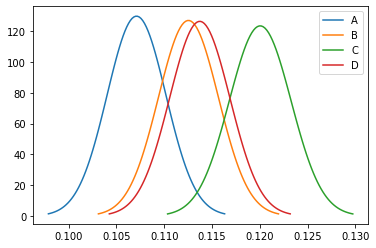

In [ ]:
# Compute the variance
a_var = (1 - a_conv) * a_conv / a_size
b_var = (1 - b_conv) * b_conv / b_size
c_var = (1 - c_conv) * c_conv / c_size
d_var = (1 - d_conv) * d_conv / d_size

# Compute the standard deviations
a_sd, b_sd, c_sd, d_sd = a_var ** 0.5, b_var ** 0.5, c_var **0.5, d_var **0.5

# Create the range of x values
a_line = np.linspace(a_conv - 3 * a_sd, a_conv + 3 * a_sd, 100)
b_line = np.linspace(b_conv - 3 * b_sd, b_conv + 3 * b_sd, 100)
c_line = np.linspace(c_conv - 3 * c_sd, c_conv + 3 * c_sd, 100)
d_line = np.linspace(d_conv - 3 * d_sd, d_conv + 3 * d_sd, 100)

# Plot the distribution
plt.plot(a_line, norm.pdf(a_line, a_conv, a_sd),label='A')
plt.plot(b_line, norm.pdf(b_line, b_conv, b_sd),label='B')
plt.plot(c_line, norm.pdf(c_line, c_conv, c_sd),label='C')
plt.plot(d_line, norm.pdf(d_line, d_conv, d_sd),label='D')
plt.legend()
plt.show()

# Conclusion

Since our C p-value is way below our α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new design (Treatment == 1 & New images == 0 & Converted == 0/1: treatment group C)  perform significantly different to the old one.

After this the recomendations is to:

#### Use the C design
#### And there are no statistical significance between control group A and treatment group B and D